# SENTIMENT BASED PRODUCT RECOMMENDATION SYSTEM

### GOAL:- To build a model that will improve the recommendations given to the users given their past reviews and ratings. 

#### Tasks Involved:
##### 1.Data sourcing and sentiment analysis
##### 2.Building a recommendation system
##### 3.Improving the recommendations using the sentiment analysis model
##### 4.Deploying the end-to-end project with a user interface

## <font color='purple'>**Importing Required Libraries**</font>

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import nltk
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

In [121]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [122]:
#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [123]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [124]:
product = pd.read_csv('/content/gdrive/MyDrive/sample30.csv',encoding="utf8",low_memory=False)
#product = pd.read_csv('sample30.csv',encoding="utf8",low_memory=False)
product.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### <font color='green'>**Data Analysis and Cleaning**</font>

In [125]:
print('rows: ', product.shape[0])
print('columns: ', product.shape[1])
print('\nfeatures: ', product.columns.to_list())
print('\nmissing vlues: ', product.isnull().values.sum())
print('\nUnique values: \n', product.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [126]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [127]:
product=product.drop_duplicates(subset=['reviews_username', 'name'], keep=False)
product.nunique()

id                        269
brand                     214
categories                268
manufacturer              226
name                      269
reviews_date             4950
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            24635
reviews_title           15909
reviews_userCity          636
reviews_userProvince       23
reviews_username        23147
user_sentiment              2
dtype: int64

In [128]:
product.shape

(25431, 15)

In [129]:
product.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              139
name                        0
reviews_date               41
reviews_didPurchase     11414
reviews_doRecommend      1866
reviews_rating              0
reviews_text                0
reviews_title             181
reviews_userCity        24404
reviews_userProvince    25382
reviews_username           10
user_sentiment              0
dtype: int64

In [130]:
# percentage of missing values in each column
null_values=round(100*(product.isnull().sum()/len(product.index)), 2).sort_values(ascending=False)
null_values.loc[null_values>0]

reviews_userProvince    99.81
reviews_userCity        95.96
reviews_didPurchase     44.88
reviews_doRecommend      7.34
reviews_title            0.71
manufacturer             0.55
reviews_date             0.16
reviews_username         0.04
dtype: float64

#### Columns [reviews_userProvince,reviews_userCity,reviews_didPurchase] have the highest Null values. Since we do not require either of the columns, we can drop them

In [131]:
#Listing columns with greater than 40% null values
Null_columns=list(null_values[null_values>=40].index)

len(Null_columns)

3

In [132]:
product = product.drop(Null_columns,axis=1)
product.shape

(25431, 12)

In [133]:
null_values=round(100*(product.isnull().sum()/len(product.index)), 2).sort_values(ascending=False)
null_values.loc[null_values>0]

reviews_doRecommend    7.34
reviews_title          0.71
manufacturer           0.55
reviews_date           0.16
reviews_username       0.04
dtype: float64

#### We can also remove the columns id,brand,categories,reviews_doRecommend,manufacturer,reviews_date as it will not be required for the analysis

In [134]:
product = product.drop(['id','brand','categories','reviews_doRecommend','manufacturer','reviews_date'],axis=1)
product.shape

(25431, 6)

In [135]:
null_values=round(100*(product.isnull().sum()/len(product.index)), 2).sort_values(ascending=False)
null_values.loc[null_values>0]

reviews_title       0.71
reviews_username    0.04
dtype: float64

#### Let us handle the Null cases in the above columns by eliminating the rows with NaN values

In [136]:
product=product.dropna()

In [137]:
product.shape

(25241, 6)

In [138]:
print("List of columns in the Dataframe:",list(product))

List of columns in the Dataframe: ['name', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment']


#### Let us now combine the columns reviews_title and reviews_text in a new Dataframe for the sentiment analysis

In [139]:
# Creating a new Dataframe with required columns
productreview=product[['name', 'reviews_rating', 'reviews_username', 'user_sentiment']]
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative
4,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative
5,K-Y Love Sensuality Pleasure Gel,1,samantha,Negative
6,K-Y Love Sensuality Pleasure Gel,1,raeanne,Negative


In [140]:
#create a combined review column using reviews_title and reviews_text

productreview['user_review']=product.reviews_title+' '+product.reviews_text

In [141]:
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,Just Awesome i love this album. it's very good...
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,Disappointed I read through the reviews on her...
4,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,Irritation My husband bought this gel for us. ...
5,K-Y Love Sensuality Pleasure Gel,1,samantha,Negative,Not worth it My boyfriend and I bought this to...
6,K-Y Love Sensuality Pleasure Gel,1,raeanne,Negative,Disappointing Bought this earlier today and wa...


## <font color='purple'>**EDA**</font>

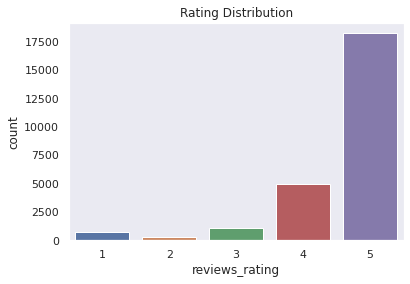

In [142]:
sns.countplot(data = productreview, x = 'reviews_rating')
plt.title('Rating Distribution')
sns.set(style="dark")
plt.show()

#### From above plot, we can make out that maximum customers have given a good rating(5)

### Let us also observe the user sentiment i.e Positive or Negative

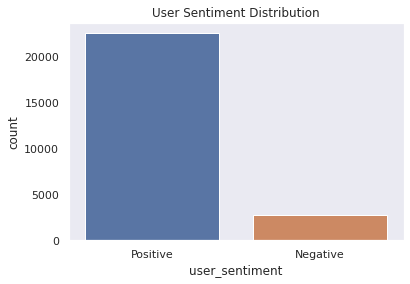

In [143]:
sns.countplot(data = productreview, x = 'user_sentiment')
plt.title('User Sentiment Distribution')
sns.set(style="dark")
plt.show()

#### The above plot depicts a clear case of Class imbalancing- we can observe that number of positive sentiments is much more than the negative sentiments

### Let us now observe the number of words used frequently in the reviews using WordCloud

In [144]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [145]:
STOPWORDS=stopwords.words('english')

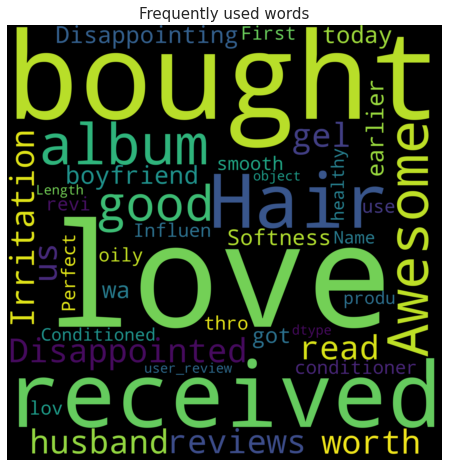

In [146]:
wordcloud = WordCloud(width = 3000, height = 3000,random_state=1,collocations=False, stopwords = STOPWORDS).generate(str(productreview["user_review"]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Frequently used words',fontsize=15)
plt.show()

## <font color='purple'>**Text Prepocessing**</font>

In [147]:
#map 1 for positive sentiment and 0 for negative sentiment
productreview["user_sentiment"] = productreview["user_sentiment"].apply(lambda x:1 if x == 'Positive' else 0)
productreview.head(5)

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,1,Just Awesome i love this album. it's very good...
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,Disappointed I read through the reviews on her...
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,Irritation My husband bought this gel for us. ...
5,K-Y Love Sensuality Pleasure Gel,1,samantha,0,Not worth it My boyfriend and I bought this to...
6,K-Y Love Sensuality Pleasure Gel,1,raeanne,0,Disappointing Bought this earlier today and wa...


In [148]:
productreview.dtypes

name                object
reviews_rating       int64
reviews_username    object
user_sentiment       int64
user_review         object
dtype: object

### As a part of text preprocessing, the below mentioned steps will be followed on the required string columns:- name, reviews_username and user_review
#### 1. Proper casing- converting the string columns to lowercase
#### 2. Removal of special characters


In [149]:
import re
for col in ['name','reviews_username','user_review']:
    #Converting to lowercasing
    productreview[col]=productreview[col].apply(lambda x: str.lower(x))
    #Removing special characters
    productreview[col]=productreview[col].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))


### Additionally, the below steps will be performed on the "*user_review*" column
#### 1. Tokenization
#### 2. Removal of stopwords


In [150]:
#Tokenization of user review col
productreview["user_review"] = productreview["user_review"].apply(lambda x:word_tokenize(x))
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,pink friday roman reloaded reup wdvd,5,joshua,1,"[just, awesome, i, love, this, album, its, ver..."
3,ky love sensuality pleasure gel,1,rebecca,0,"[disappointed, i, read, through, the, reviews,..."
4,ky love sensuality pleasure gel,1,walker557,0,"[irritation, my, husband, bought, this, gel, f..."
5,ky love sensuality pleasure gel,1,samantha,0,"[not, worth, it, my, boyfriend, and, i, bought..."
6,ky love sensuality pleasure gel,1,raeanne,0,"[disappointing, bought, this, earlier, today, ..."


In [151]:
#Removal of stopwords from user review col
productreview["user_review"] = productreview["user_review"].apply(lambda x:[word for word in x if word not in STOPWORDS])
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,pink friday roman reloaded reup wdvd,5,joshua,1,"[awesome, love, album, good, hip, hop, side, c..."
3,ky love sensuality pleasure gel,1,rebecca,0,"[disappointed, read, reviews, looking, buying,..."
4,ky love sensuality pleasure gel,1,walker557,0,"[irritation, husband, bought, gel, us, gel, ca..."
5,ky love sensuality pleasure gel,1,samantha,0,"[worth, boyfriend, bought, spice, things, bedr..."
6,ky love sensuality pleasure gel,1,raeanne,0,"[disappointing, bought, earlier, today, excite..."


### Performing Stemming and Lemmatization

In [152]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [153]:
productreview["user_review"] = productreview["user_review"].apply(lambda x:[stemmer.stem(word) for word in x])
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,pink friday roman reloaded reup wdvd,5,joshua,1,"[awesom, love, album, good, hip, hop, side, cu..."
3,ky love sensuality pleasure gel,1,rebecca,0,"[disappoint, read, review, look, buy, one, cou..."
4,ky love sensuality pleasure gel,1,walker557,0,"[irrit, husband, bought, gel, us, gel, caus, i..."
5,ky love sensuality pleasure gel,1,samantha,0,"[worth, boyfriend, bought, spice, thing, bedro..."
6,ky love sensuality pleasure gel,1,raeanne,0,"[disappoint, bought, earlier, today, excit, ch..."


In [154]:
productreview["user_review"] = productreview["user_review"].apply(lambda x:[lemmatizer.lemmatize(word, pos='v') for word in x])
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,pink friday roman reloaded reup wdvd,5,joshua,1,"[awesom, love, album, good, hip, hop, side, cu..."
3,ky love sensuality pleasure gel,1,rebecca,0,"[disappoint, read, review, look, buy, one, cou..."
4,ky love sensuality pleasure gel,1,walker557,0,"[irrit, husband, buy, gel, us, gel, caus, irri..."
5,ky love sensuality pleasure gel,1,samantha,0,"[worth, boyfriend, buy, spice, thing, bedroom,..."
6,ky love sensuality pleasure gel,1,raeanne,0,"[disappoint, buy, earlier, today, excit, check..."


### Convert user review col to string post stemming and lemmatization

In [155]:
productreview["user_review"] = productreview["user_review"].apply(lambda x:' '.join(x))
productreview.head()

,name,reviews_rating,reviews_username,user_sentiment,user_review
0,pink friday roman reloaded reup wdvd,5,joshua,1,awesom love album good hip hop side current po...
3,ky love sensuality pleasure gel,1,rebecca,0,disappoint read review look buy one coupl lubr...
4,ky love sensuality pleasure gel,1,walker557,0,irrit husband buy gel us gel caus irrit felt l...
5,ky love sensuality pleasure gel,1,samantha,0,worth boyfriend buy spice thing bedroom highli...
6,ky love sensuality pleasure gel,1,raeanne,0,disappoint buy earlier today excit check base ...


# <font color='green'>**Sentiment Analysis**</font>

## <font color='purple'>**Splitting into Train and Test Dataset**</font>

In [156]:
X = productreview["user_review"]
y = productreview["user_sentiment"]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state = 100)

In [158]:
X_train.shape, X_test.shape

((17668,), (7573,))

#### Creating bag of words model using count vectorizer function

In [159]:
vectorizer = TfidfVectorizer(max_features = 6000,analyzer = 'word')
fe_X_train = vectorizer.fit_transform(X_train).toarray()
fe_X_test = vectorizer.transform(X_test)

In [160]:
print(fe_X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [161]:
print(fe_X_test)

  (0, 5762)	0.35690511282248477
  (0, 5229)	0.25569149214541304
  (0, 3382)	0.18273857297018536
  (0, 3364)	0.2278672330219958
  (0, 3078)	0.09652262839323641
  (0, 2860)	0.18303892134382055
  (0, 1537)	0.4584626396805998
  (0, 1382)	0.577523022943337
  (0, 596)	0.3679443447291718
  (1, 5465)	0.36301594480936455
  (1, 5229)	0.3317024323927216
  (1, 4704)	0.26612906243902695
  (1, 4353)	0.13627093183845046
  (1, 4242)	0.395845993021262
  (1, 4022)	0.1389026299677363
  (1, 3996)	0.1399601784659438
  (1, 3705)	0.13667118768595912
  (1, 2468)	0.36354518591830437
  (1, 1543)	0.2842557353514183
  (1, 1320)	0.3313903876531332
  (1, 1113)	0.13503853064616633
  (1, 382)	0.336929073315066
  (2, 5921)	0.10776228833283848
  (2, 5884)	0.13034482678197365
  (2, 5867)	0.23538464618088364
  :	:
  (7571, 2589)	0.34806959058125414
  (7571, 1889)	0.3761541304715733
  (7571, 1230)	0.36360600267865373
  (7571, 1113)	0.1987579822041329
  (7571, 1073)	0.2568902490710309
  (7571, 411)	0.40098589910869575
  (7

In [162]:
print("Shape of Train TFIDF:",fe_X_train.shape) 
print("Shape of Test TFIDF:",fe_X_test.shape)

Shape of Train TFIDF: (17668, 6000)
Shape of Test TFIDF: (7573, 6000)


#### Handling class imbalance

In [163]:
print("Counts of label '1',before OverSampling: {}".format(sum(y_train==1)))
print("Counts of label '0',before OverSampling: {} \n".format(sum(y_train==0)))
print("Churn event rate, Before OverSampling : {}% \n".format(round(sum(y_train==1)/len(y_train)*100,2)))

Counts of label '1',before OverSampling: 15732
Counts of label '0',before OverSampling: 1936 

Churn event rate, Before OverSampling : 89.04% 



In [164]:
sm = SMOTE(random_state=100, sampling_strategy = 1)
X_train_sm, y_train_sm = sm.fit_resample(fe_X_train, y_train)

In [165]:
print('Shape of train_X after OverSampling: {}'.format(X_train_sm.shape))
print('Shape of train_y after OverSampling: {} \n'.format(y_train_sm.shape))

print("Counts of label '1',after OverSampling: {}".format(sum(y_train_sm==1)))
print("Counts of label '0',after OverSampling: {}".format(sum(y_train_sm==0)))
print("Churn event rate,after OverSampling: {}% \n".format(round(sum(y_train_sm==1)/len(y_train_sm)*100,2)))

Shape of train_X after OverSampling: (31464, 6000)
Shape of train_y after OverSampling: (31464,) 

Counts of label '1',after OverSampling: 15732
Counts of label '0',after OverSampling: 15732
Churn event rate,after OverSampling: 50.0% 



## <font color='purple'>**Model Building**</font>

### Model-1 Logistic Regression

In [166]:
logreg = LogisticRegression()
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'class_weight' : ['balanced']}

In [119]:
# 4- fold cross validation
grid_search = GridSearchCV(logreg, grid_values, cv = 4, scoring = 'roc_auc', n_jobs = -1)
grid_search.fit(X_train_sm, y_train_sm)
model1 = grid_search.best_estimator_
model1.fit(X_train_sm, y_train_sm)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [167]:
model1 = LogisticRegressionCV(cv=4,scoring = 'roc_auc', n_jobs = -1).fit (X_train_sm, y_train_sm)

### Model 1 Evaluation

In [168]:
y_pro_test = model1.predict_proba(fe_X_test)
y_pre_test = model1.predict(fe_X_test)
print("\033[1m Test Score on Logistic Regression model: \033[0m")
print('----------------------Confusion Matrix----------------------')
print(confusion_matrix(y_test, y_pre_test))
print('----------------------Classification Report----------------------')
print(classification_report(y_test, y_pre_test))
print('----------------------AUC-ROC----------------------')
print(roc_auc_score(y_test, y_pro_test[:,1]))

FPR_model1, TPR_model1, Thresholds_model1 = roc_curve(y_test, y_pro_test[:,1])
AUC_ROC_model1 = roc_auc_score(y_test, y_pro_test[:,1])

 Test Score on Logistic Regression model: 
----------------------Confusion Matrix----------------------
[[ 522  282]
 [ 722 6047]]
----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       0.42      0.65      0.51       804
           1       0.96      0.89      0.92      6769

    accuracy                           0.87      7573
   macro avg       0.69      0.77      0.72      7573
weighted avg       0.90      0.87      0.88      7573

----------------------AUC-ROC----------------------
0.8779483069215894


### model 2- Random Forest

In [169]:
from sklearn.model_selection import StratifiedKFold

In [170]:
# random forest
rf = RandomForestClassifier(random_state = 101)
params_rf = {'max_depth':[5, 10, 15], 
             'min_samples_leaf' : [5, 10, 15], 
             'n_estimators': [10,20,30]}

random_search = RandomizedSearchCV(rf, params_rf, cv = 4, n_jobs = -1, verbose = 1, scoring = 'roc_auc')
random_search.fit(X_train_sm, y_train_sm)
model2 = random_search.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished


### Model -2 Evaluation

In [171]:
y_pro_test = model2.predict_proba(fe_X_test)
y_pre_test = model2.predict(fe_X_test)
print("\033[1m Test Score on Random Forest model: \033[0m")
print('----------------------Confusion Matrix----------------------')
print(confusion_matrix(y_test, y_pre_test))
print('----------------------Classification Report----------------------')
print(classification_report(y_test, y_pre_test))
print('----------------------AUC-ROC----------------------')
print(roc_auc_score(y_test, y_pro_test[:,1]))

FPR_model2, TPR_model2, Thresholds_model2 = roc_curve(y_test, y_pro_test[:,1])
AUC_ROC_model2 = roc_auc_score(y_test, y_pro_test[:,1])

 Test Score on Random Forest model: 
----------------------Confusion Matrix----------------------
[[ 434  370]
 [ 967 5802]]
----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       0.31      0.54      0.39       804
           1       0.94      0.86      0.90      6769

    accuracy                           0.82      7573
   macro avg       0.62      0.70      0.65      7573
weighted avg       0.87      0.82      0.84      7573

----------------------AUC-ROC----------------------
0.8200991643937205


### Model-3 Naive Bayes

In [172]:
nb = MultinomialNB()
model3 = nb.fit(X_train_sm, y_train_sm)

### Model-3 evaluation

In [173]:
y_pro_test = model3.predict_proba(fe_X_test)
y_pre_test = model3.predict(fe_X_test)
print("\033[1m Test Score on Naive Bayes model: \033[0m")
print('----------------------Confusion Matrix----------------------')
print(confusion_matrix(y_test, y_pre_test))
print('----------------------Classification Report----------------------')
print(classification_report(y_test, y_pre_test))
print('----------------------AUC-ROC----------------------')
print(roc_auc_score(y_test, y_pro_test[:,1]))

FPR_model3, TPR_model3, Thresholds_model3 = roc_curve(y_test, y_pro_test[:,1])
AUC_ROC_model3 = roc_auc_score(y_test, y_pro_test[:,1])

 Test Score on Naive Bayes model: 
----------------------Confusion Matrix----------------------
[[ 501  303]
 [1065 5704]]
----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       0.32      0.62      0.42       804
           1       0.95      0.84      0.89      6769

    accuracy                           0.82      7573
   macro avg       0.63      0.73      0.66      7573
weighted avg       0.88      0.82      0.84      7573

----------------------AUC-ROC----------------------
0.8156442267904092


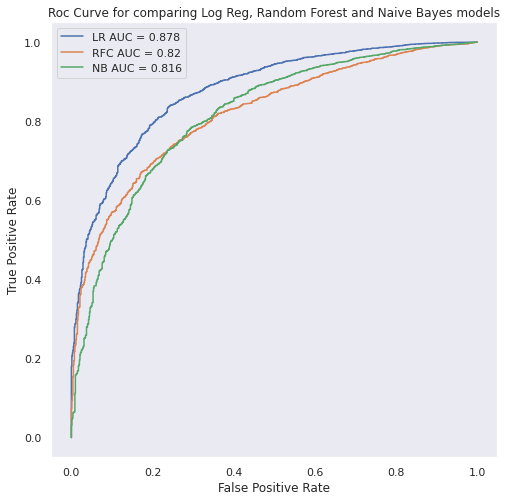

In [174]:
# ROC plot
plt.figure(figsize = (8,8))
plt.plot(FPR_model1, TPR_model1, label = f'LR AUC = {round(AUC_ROC_model1, 3)}' )
plt.plot(FPR_model2, TPR_model2, label = f'RFC AUC = {round(AUC_ROC_model2, 3)}' )
plt.plot(FPR_model3, TPR_model3, label = f'NB AUC = {round(AUC_ROC_model3, 3)}' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve for comparing Log Reg, Random Forest and Naive Bayes models')
plt.legend()
plt.show()

## From the above graph, it is evident that Logistic Regression model is the best performing model

In [175]:
# saving model as pickle file
with open("tfidf_model.pkl", 'wb') as file:
  pickle.dump(vectorizer, file)

with open("Logistic_regression_Model.pkl", 'wb') as file:
  pickle.dump(model1, file)

with open("cleaned_df.pkl", 'wb') as file:
  pickle.dump(productreview, file)

# <font color='green'>**Recommendation System**</font>

In [176]:
# Creating Recommendation Dataframe
rec_df = productreview[["reviews_username", "reviews_rating", "name"]]
rec_df.head()

,reviews_username,reviews_rating,name
0,joshua,5,pink friday roman reloaded reup wdvd
3,rebecca,1,ky love sensuality pleasure gel
4,walker557,1,ky love sensuality pleasure gel
5,samantha,1,ky love sensuality pleasure gel
6,raeanne,1,ky love sensuality pleasure gel


### Spliting Dataset into Train and Test

In [177]:
train, test = train_test_split(rec_df, test_size = 0.3, random_state = 101)

In [178]:
train.shape, test.shape


((17668, 3), (7573, 3))

In [179]:
# checking unique values in username and product name
print(train["reviews_username"].nunique())
print(train["name"].nunique())

16473
234


In [180]:
# creating matrix with products as columns and users as rows 
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [181]:
df_pivot.shape

(16473, 234)

In [182]:
# creating dummy train and test data to recommend products that are not seen by customers earlier
train_dummy = train.copy()

# products not rated by user is given as 1, else 0 
train_dummy["reviews_rating"]= train_dummy["reviews_rating"].apply(lambda x:1 if x==0 else 0)

# creating matrix with products as columns and users as rows 
df_pivot_dummy = train_dummy.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot_dummy = df_pivot_dummy.fillna(1)
df_pivot_dummy.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [183]:
df_pivot_dummy.shape

(16473, 234)

In [184]:
# similarity matrix
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [185]:
# Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(df_pivot, axis = 1)
df_subtract = (df_pivot.T-mean).T
df_subtract.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [186]:
df_subtract.shape

(16473, 234)

In [187]:
# calculation pairwise distnce between users
user_corr = 1 - pairwise_distances(df_subtract.fillna(0), metric = 'cosine')
user_corr[np.isnan(user_corr)] = 0
user_corr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [188]:
user_corr[user_corr < 0] = 0
user_corr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted is the weigted sum of correlation with the product rating

In [189]:
user_rating_pred = np.dot(user_corr, df_pivot.fillna(0))
user_rating_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.76699295, 0.        , ..., 2.09444934, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [190]:
user_rating_pred.shape

(16473, 234)

In [191]:
# predicted rating of products
user_rating_final = np.multiply(user_rating_pred, df_pivot_dummy)
user_rating_final.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.

# Top 20 Recommendation

In [192]:
# input -> reviews_username
# chekcing for one user
input = str('00sab00')

In [193]:
top_20_recommendation = user_rating_final.loc[input].sort_values(ascending = False)[:20]
top_20_recommendation

name
godzilla 3d includes digital copy ultraviolet 3d2d bluraydvd                  16.872489
planes fire rescue 2 discs includes digital copy bluraydvd                    12.223251
clorox disinfecting wipes value pack scented 150 ct total                      8.474128
coty airspun face powder translucent extra coverage                            7.234215
holmes174 personal indoor heater w manual controls white 1500w hfh131n         5.280518
theres something about mary dvd                                                5.000000
equals bluray                                                                  4.000000
clorox disinfecting bathroom cleaner                                           3.941497
hormel chili no beans                                                          3.825383
bisquick original pancake and baking mix  40oz                                 3.819709
the resident evil collection 5 discs bluray                                    3.787614
alex cross dvdvideo        

# Evaluating Recomendations

In [194]:
# fetching common users in train and test dataset
common_users = test[test["reviews_username"].isin(train["reviews_username"])]
common_users.head()

,reviews_username,reviews_rating,name
17587,hazel,5,allbran complete wheat flakes 18 oz
7432,luke,4,clorox disinfecting wipes value pack scented 1...
12999,robin3,5,clorox disinfecting wipes value pack scented 1...
24271,busymom,4,godzilla 3d includes digital copy ultraviolet ...
20387,le30,5,clorox disinfecting bathroom cleaner


In [195]:
common_users.shape

(891, 3)

In [196]:
# creating matrix with users as rows and product as columns
common_user_pivot = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
user_corr_df = pd.DataFrame(user_corr)

In [197]:
user_corr_df["User_Id"] = df_subtract.index
user_corr_df.set_index('User_Id', inplace = True)
user_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16433,16434,16435,16436,16437,16438,16439,16440,16441,16442,16443,16444,16445,16446,16447,16448,16449,16450,16451,16452,16453,16454,16455,16456,16457,16458,16459,16460,16461,16462,16463,16464,16465,16466,16467,16468,16469,16470,16471,16472
User_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
common_users.head()

,reviews_username,reviews_rating,name
17587,hazel,5,allbran complete wheat flakes 18 oz
7432,luke,4,clorox disinfecting wipes value pack scented 1...
12999,robin3,5,clorox disinfecting wipes value pack scented 1...
24271,busymom,4,godzilla 3d includes digital copy ultraviolet ...
20387,le30,5,clorox disinfecting bathroom cleaner


In [199]:
users_list = common_users["reviews_username"].tolist()
user_corr_df.columns = df_subtract.index.tolist()
user_corr_df_1 = user_corr_df[user_corr_df.index.isin(users_list)]
user_corr_df_1.shape

(751, 16473)

In [200]:
user_corr_df_2 = user_corr_df_1.T[user_corr_df_1.T.index.isin(users_list)]
user_corr_df_3 = user_corr_df_2.T
user_corr_df_3.head()

,50cal,aaron,abbi,acg1,actionaction,acv4217,ah78,aisha,ajay,ajeff,alex,alexa86,alexis,alice,allan6048,allie,allison33,ally,amanda,amandarose,amazing,amcomber,ammi,amsmes26,amy1,amy75,anas,anatnas4,andrea,andreafl,angel,angela,angie,angie2,anna1202,anne,annie,anthony,april,aprilg87,...,tjzmom,tman,tobaira,toby,todd,toddster7,tone,toni,tonybdub,toots,treesmith,trix,truth,turi,tweetyanne,tyler,valerie,vallink,vet323tech,vickie456,vicky,viewer,vikki,vivian,wally,want297z,wendy,whome,wildclay12,willy,wind,winniepoo2,wiseman378,wonderwoman,wvshopaholic,xmom,xstr8edgex,zach,zippy,zmom
User_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acg1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
actionaction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
user_corr_df_3.shape

(751, 751)

In [202]:
user_corr_df_3[user_corr_df_3<0] = 0
common_users_rating_pred = np.dot(user_corr_df_3, common_user_pivot.fillna(0))
common_users_rating_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.5       , 0.        , ..., 0.        , 0.        ,
        0.57735027],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [203]:
test_dummy = common_users.copy()
test_dummy["reviews_rating"] = test_dummy["reviews_rating"].apply(lambda x: 1 if x>= 1 else 0)
test_dummy = test_dummy.pivot_table(index = 'reviews_username', columns = "name", values = "reviews_rating").fillna(0)

In [204]:
common_user_rating_pred = np.multiply(common_users_rating_pred, test_dummy)
common_user_rating_pred.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,alex cross dvdvideo,allbran complete wheat flakes 18 oz,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,avery174 ready index contemporary table of contents divider 18 multi letter,banana boat sunless summer color self tanning lotion light to medium,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,cantu coconut milk shine hold mist 8oz,care free curl gold instant activator,caress moisturizing body bar natural silk 475oz,cars toon maters tall tales,cheetos crunchy flamin hot cheese flavored snacks,chesters cheese flavored puffcorn snacks,chips ahoy original chocolate chip cookies family size 182oz,chips deluxe soft n chewy cookies,clear scalp hair therapy total care nourishing shampoo,clorox disinfecting bathroom cleaner,clorox disinfecting wipes value pack scented 150 ct total,cococare 100 natural castor oil,coty airspun face powder translucent extra coverage,creme of nature intensive conditioning treatment 32,cuisinart174 electric juicer stainless steel cje1000,dark shadows includes digital copy ultraviolet dvdvideo,dcon mice bait station 3ct,diet canada dry ginger ale 12pk12 fl oz cans,eagle fat free sweetened condensed milk,equals bluray,fiskars174 classic stick rotary cutter 45 mm,godzilla 3d includes digital copy ultraviolet 3d2d bluraydvd,happy tot apple and butternut squash,...,nexxus exxtra gel style creation sculptor,ogx conditioner hydrating teatree mint,olay regenerist deep hydration regenerating cream,orajel maximum strength toothache pain relief liquid,pantene prov expert collection age defy conditioner,pendaflex174 divide it up file folder multi section letter assorted 12pack,planes fire rescue 2 discs includes digital copy bluraydvd,pleasant hearth 1800 sq ft wood burning stove with blower medium lws127201,pleasant hearth diamond fireplace screen espresso,post bound jumbo album burgundy 11x14,power crunch protein energy bar peanut butter creme original,queen helene cocoa butter solid,ragu roasted garlic parmesan pasta sauce,ragu traditional pasta sauce,red special edition dvdvideo,scooby doo and the loch ness monster bluray,solo foods poppy seed cake and pastry filling,sopranosseason 6 part 1 bluray,stacys simply naked bagel chips,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,tai pei sweet sour chicken,the resident evil collection 5 discs bluray,the script no sound without silence cd,theres something about mary dvd,tostitos bite size tortilla chips,tostitos simply blue corn tortilla chips,tree hut shea body butters coconut lime 7 oz,tresemme kertatin smooth infusing conditioning,various countrys greatest gospelgold ed cd,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,wagan smartac 80watt inverter with usb,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Estimating RMSE

In [205]:
X = common_user_rating_pred.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range = (1,5))
print(scaler.fit(X))
y = scaler.transform(X)
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [206]:
common_rmse = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
common_rmse.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,alex cross dvdvideo,allbran complete wheat flakes 18 oz,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,avery174 ready index contemporary table of contents divider 18 multi letter,banana boat sunless summer color self tanning lotion light to medium,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,cantu coconut milk shine hold mist 8oz,care free curl gold instant activator,caress moisturizing body bar natural silk 475oz,cars toon maters tall tales,cheetos crunchy flamin hot cheese flavored snacks,chesters cheese flavored puffcorn snacks,chips ahoy original chocolate chip cookies family size 182oz,chips deluxe soft n chewy cookies,clear scalp hair therapy total care nourishing shampoo,clorox disinfecting bathroom cleaner,clorox disinfecting wipes value pack scented 150 ct total,cococare 100 natural castor oil,coty airspun face powder translucent extra coverage,creme of nature intensive conditioning treatment 32,cuisinart174 electric juicer stainless steel cje1000,dark shadows includes digital copy ultraviolet dvdvideo,dcon mice bait station 3ct,diet canada dry ginger ale 12pk12 fl oz cans,eagle fat free sweetened condensed milk,equals bluray,fiskars174 classic stick rotary cutter 45 mm,godzilla 3d includes digital copy ultraviolet 3d2d bluraydvd,happy tot apple and butternut squash,...,nexxus exxtra gel style creation sculptor,ogx conditioner hydrating teatree mint,olay regenerist deep hydration regenerating cream,orajel maximum strength toothache pain relief liquid,pantene prov expert collection age defy conditioner,pendaflex174 divide it up file folder multi section letter assorted 12pack,planes fire rescue 2 discs includes digital copy bluraydvd,pleasant hearth 1800 sq ft wood burning stove with blower medium lws127201,pleasant hearth diamond fireplace screen espresso,post bound jumbo album burgundy 11x14,power crunch protein energy bar peanut butter creme original,queen helene cocoa butter solid,ragu roasted garlic parmesan pasta sauce,ragu traditional pasta sauce,red special edition dvdvideo,scooby doo and the loch ness monster bluray,solo foods poppy seed cake and pastry filling,sopranosseason 6 part 1 bluray,stacys simply naked bagel chips,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,tai pei sweet sour chicken,the resident evil collection 5 discs bluray,the script no sound without silence cd,theres something about mary dvd,tostitos bite size tortilla chips,tostitos simply blue corn tortilla chips,tree hut shea body butters coconut lime 7 oz,tresemme kertatin smooth infusing conditioning,various countrys greatest gospelgold ed cd,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,wagan smartac 80watt inverter with usb,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Item Based Similarity 

In [207]:
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T
df_pivot.head()


reviews_username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,111e24,1143mom,11677j,1234,123cat123,123numbers,123soccermom,123too,127726,12cass12,132457,13ram,13thfaerie,148maine,15425shopper,1616,1753,17roses,1863philly,1968bear,1979edes,19bubba67,1cadet,1chynna,1clean1,1cocoafan,1derpet1,1friendlycat,1glenn,1gussy,1healthytot,1izzy1,1jc1,...,zina911,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zodness,zoe1988,zoey,zoeyny,zokhid,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zooey57,zookeeper,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsarah,zt313,zulaa118,zuttle,zwithanx,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
06 cu ft letter a4 size waterproof 30 min fire file chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100complete first season bluray,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20172018 brownline174 duraflex 14month planner 8 12 x 11 black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2x ultra era with oxi booster 50fl oz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42 dual drop leaf table with 2 madrid chairs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
mean = np.nanmean(df_pivot, axis = 1)
df_subtract = (df_pivot.T - mean).T
df_subtract.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,111e24,1143mom,11677j,1234,123cat123,123numbers,123soccermom,123too,127726,12cass12,132457,13ram,13thfaerie,148maine,15425shopper,1616,1753,17roses,1863philly,1968bear,1979edes,19bubba67,1cadet,1chynna,1clean1,1cocoafan,1derpet1,1friendlycat,1glenn,1gussy,1healthytot,1izzy1,1jc1,...,zina911,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zodness,zoe1988,zoey,zoeyny,zokhid,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zooey57,zookeeper,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsarah,zt313,zulaa118,zuttle,zwithanx,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
06 cu ft letter a4 size waterproof 30 min fire file chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100complete first season bluray,NaN,NaN,NaN,NaN,NaN,0.255319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20172018 brownline174 duraflex 14month planner 8 12 x 11 black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2x ultra era with oxi booster 50fl oz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42 dual drop leaf table with 2 madrid chairs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
# item similarity
item_corr = 1-pairwise_distances(df_subtract.fillna(0), metric = 'cosine')
item_corr[np.isnan(item_corr)] = 0
print(item_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [210]:
item_corr[item_corr<0] = 0
item_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [211]:
# prediction
item_rating_pred = np.dot((df_pivot.fillna(0).T), item_corr)
item_rating_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00155179, 0.00481202,
        0.        ],
       [0.        , 0.01443408, 0.        , ..., 0.        , 0.00437425,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00189235, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00473087, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00802004,
        0.        ]])

In [212]:
item_rating_pred.shape

(16473, 234)

In [213]:
item_rating_final = np.multiply(item_rating_pred, df_pivot_dummy)
item_rating_final.head()

name,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,42 dual drop leaf table with 2 madrid chairs,4c grated parmesan cheese 100 natural 8oz shaker,5302050 1516 fcthose adaptor,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 1114 x 914 index maker extra wide label dividers with 5 tab clear 5 sets per pack,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,blue anchor design throw pillow 18x18 rizzy home,bodycology nourishing body cream pretty in paris,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cal lighting led dark bronze finish metal piano lamp,calvin klein secret obsession eau de parfum,...,stacys simply naked bagel chips,stander pt bedcane bed handle,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,the seaweed bath co argan conditioner smoothing citrus,theres something about mary dvd,tim holtz retractable craft pickred 6x5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tramontina ceramica 10 piece cookware set red,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,udis pepperoni pizza,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,wallmount server cabinet 450mm 9 ru,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,wedding wishes wedding guest book,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.012732,0.0,0.006387,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0

In [214]:
# input is user name
input = str('00sab00')

In [215]:
# recommending top 20 products to the user
op1 = item_rating_final.loc[input].sort_values(ascending = False)[:20]
op1

name
wagan smartac 80watt inverter with usb                                        0.064366
equals bluray                                                                 0.053033
the resident evil collection 5 discs bluray                                   0.023304
clear scalp  hair therapy total care nourishing shampoo                       0.020435
planes fire rescue 2 discs includes digital copy bluraydvd                    0.017807
iman second to none stick foundation clay 1                                   0.016449
chex muddy buddies brownie supreme snack mix                                  0.015635
coty airspun face powder translucent extra coverage                           0.014531
hawaiian punch berry limeade blast juice                                      0.013306
pleasant hearth 75 steel grate 30 5 bar  black                                0.012538
red special edition dvdvideo                                                  0.012133
pendaflex174 divide it up file folder 

## Evaluation

In [216]:
common_users = test[test['name'].isin(train['name'])]
common_users.shape

(7556, 3)

In [217]:
common_pivot = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T
common_pivot.shape

(186, 7282)

In [218]:
item_corr_df = pd.DataFrame(item_corr)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
item_corr_df['name'] = df_subtract.index
item_corr_df.set_index('name', inplace = True)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
06 cu ft letter a4 size waterproof 30 min fire file chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100complete first season bluray,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20172018 brownline174 duraflex 14month planner 8 12 x 11 black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2x ultra era with oxi booster 50fl oz,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42 dual drop leaf table with 2 madrid chairs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
product_list = common_users["name"].tolist()
item_corr_df.columns = df_subtract.index.tolist()
item_corr_df_1 = item_corr_df[item_corr_df.index.isin(product_list)]

item_corr_df_2 = item_corr_df_1.T[item_corr_df_1.T.index.isin(product_list)]
item_corr_df_3 = item_corr_df_2.T
item_corr_df_3.head()

,06 cu ft letter a4 size waterproof 30 min fire file chest,100complete first season bluray,20172018 brownline174 duraflex 14month planner 8 12 x 11 black,2x ultra era with oxi booster 50fl oz,4c grated parmesan cheese 100 natural 8oz shaker,africas best nolye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross dvdvideo,allbran complete wheat flakes 18 oz,ambi complexion cleansing bar,annies homegrown deluxe elbows four cheese sauce,annies homegrown gluten free double chocolate chip granola bars,arrid extra dry antiperspirant deodorant spray regular,aussie aussome volume shampoo 135 oz,australian gold exotic blend lotion spf 4,aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55 4oz,avery174 ready index contemporary table of contents divider 18 multi letter,axe dry antiperspirant deodorant invisible solid phoenix,banana boat sunless summer color self tanning lotion light to medium,barielle nail rebuilding protein,baxter of california cream pomade,bedtime originals pinkie musical mobile,ben jerrys coffee coffee buzzbuzzbuzz ice cream pint,bilbao nightstand gray oak south shore,bill glor gaither church in the wildwood cd,biokleen spray wipe all purpose cleaner,bisquick original pancake and baking mix 40oz,black front loading frame set 85x11 set of 12,boraam sonoma kitchen cart with wire brush gray maaya home,bounce dryer sheets fresh linen 160 sheets,bumble bee solid white albacore in water 5 oz,burts bees lip shimmer raisin,burts bees lip shimmer watermelon,cantu coconut milk shine hold mist 8oz,care free curl gold instant activator,caress moisturizing body bar natural silk 475oz,cars toon maters tall tales,cerave sa renewing cream,cetaphil gentle skin cleanser 2oz,cheetos crunchy flamin hot cheese flavored snacks,...,scooby doo and the loch ness monster bluray,shea moisture mango carrot kids extranourishing conditioner 8fl oz,simple green allpurpose cleaner 16oz,sizzix framelits dies 1by tim holtz bird crazysilver asst sizes,smead174 3in1 supertab section folders 13 cut top tab letter assorted 12pack,solo foods almond paste,solo foods poppy seed cake and pastry filling,sopranosseason 6 part 1 bluray,spam single classic,stacys simply naked bagel chips,starbucks iced expresso classics vanilla latte coffee beverage 40oz,starbucks153 doubleshot protein coffee 11 fl oz,stargate ws ultimate edition directors cut dvdvideo,storkcraft tuscany glider and ottoman beige cushions espresso finish,suave professionals hair conditioner sleek,super poligrip denture adhesive cream ultra fresh 24 oz,switchmas dvd,tai pei sweet sour chicken,the honest company laundry detergent,the resident evil collection 5 discs bluray,the script no sound without silence cd,theres something about mary dvd,tostitos bite size tortilla chips,tostitos simply blue corn tortilla chips,toy story kids woody accessory kit,tree hut shea body butters coconut lime 7 oz,trend lab park nursing cover paisley,tresemme kertatin smooth infusing conditioning,various red hot bluetribute to cole porter cd,various artists choo choo soul cd,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,vicks vaporub regular 353oz,voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,way basics 3shelf eco narrow bookcase storage shelf espresso formaldehyde free lifetime guarantee,weleda everon lip balm,windex original glass cleaner refill 676oz 2 liter,yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
06 cu ft letter a4 size waterproof 30 min fire file chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000

In [221]:
item_corr_df_3[item_corr_df_3 < 0] = 0
common_item_rating_pred = np.dot(item_corr_df_3, common_pivot.fillna(0))
common_item_rating_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00866045, 0.        , 0.        , ..., 0.        , 0.02691527,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00473087, 0.        , ..., 0.00293262, 0.        ,
        0.0037847 ],
       [0.00262455, 0.        , 0.00802004, ..., 0.        , 0.004203  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [222]:
common_item_rating_pred.shape

(186, 7282)

In [223]:
test_dummy = common_users.copy()
test_dummy["reviews_rating"] = test_dummy["reviews_rating"].apply(lambda x:1 if x>=1 else 0)
test_dummy_pivot = test_dummy.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T.fillna(0)
common_item_rating_pred = np.multiply(common_item_rating_pred, test_dummy_pivot)


In [224]:
common_rmse = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T

In [225]:
# claculating rmse
X = common_item_rating_pred.copy()
X = X[X>0]
scaler = MinMaxScaler(feature_range = (1,5))
print(scaler.fit(X))
y = scaler.fit_transform(X)
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


## Recomendation of top 5 products to user

In [226]:
# saving the model and predicted values
user_rating_final.to_csv('User_based_recommendation.csv')
pickle.dump(user_rating_final, open('User_based_recommendation_model.pkl', 'wb'))

In [227]:
# loading all pickle files
tf_idf_model = pickle.load(open('tfidf_model.pkl', 'rb'))
User_based_recommendation_model = pickle.load(open('User_based_recommendation_model.pkl', 'rb'))
LR_sentiment_model = pickle.load(open('Logistic_regression_Model.pkl', 'rb'))
Clean_data = pickle.load(open('cleaned_df.pkl', 'rb'))


In [228]:
input = str('00sab00')

In [229]:
# Top 20 recommendations
user_top_20 = User_based_recommendation_model.loc[input].sort_values(ascending = False)[:20]
user_top_20 = pd.DataFrame(user_top_20)
user_top_20.reset_index(inplace = True)
user_top_20

,name,00sab00
0,godzilla 3d includes digital copy ultraviolet ...,16.872489
1,planes fire rescue 2 discs includes digital co...,12.223251
2,clorox disinfecting wipes value pack scented 1...,8.474128
3,coty airspun face powder translucent extra cov...,7.234215
4,holmes174 personal indoor heater w manual cont...,5.280518
5,theres something about mary dvd,5.000000
6,equals bluray,4.000000
7,clorox disinfecting bathroom cleaner,3.941497
8,hormel chili no beans,3.825383
9,bisquick original pancake and baking mix 40oz,3.819709


In [230]:
# merging top 20 products with reviews
top_20_sentiment = pd.merge(user_top_20, Clean_data, on = ['name'])
top_20_sentiment.head()

,name,00sab00,reviews_rating,reviews_username,user_sentiment,user_review
0,godzilla 3d includes digital copy ultraviolet ...,16.872489,1,primoconcept,1,aw could leave one shelf great box
1,godzilla 3d includes digital copy ultraviolet ...,16.872489,1,terrym,1,much wors expect movi much wors expect 1997 br...
2,godzilla 3d includes digital copy ultraviolet ...,16.872489,1,mrme,0,dont get hype dont get hype godzilla frankli m...
3,godzilla 3d includes digital copy ultraviolet ...,16.872489,1,3dknights,0,best item littl disappoint like godzilla movi ...
4,godzilla 3d includes digital copy ultraviolet ...,16.872489,1,master,0,good movi bad packag sale buy get case break h...


In [231]:
# Feeding top 20 df into tfidf and then sentiment model to get sentimentscore
top20_tfidf = tf_idf_model.transform(top_20_sentiment["user_review"])

In [232]:
top20_pred = LR_sentiment_model.predict(top20_tfidf)
top20_pred

array([0, 1, 1, ..., 1, 1, 1])

In [233]:
top_20_sentiment['pred_sentiment_score'] = top20_pred

In [234]:
sentiment_score = top_20_sentiment.groupby(['name'])['pred_sentiment_score'].agg(['sum', 'count']).reset_index()
sentiment_score['percentage'] = round((100*sentiment_score['sum'] / sentiment_score['count']),2)
sentiment_score

,name,sum,count,percentage
0,100complete first season bluray,110,131,83.97
1,alex cross dvdvideo,111,139,79.86
2,bisquick original pancake and baking mix 40oz,81,92,88.04
3,burts bees lip shimmer raisin,717,873,82.13
4,caress moisturizing body bar natural silk 475oz,57,68,83.82
5,cars toon maters tall tales,31,34,91.18
6,clorox disinfecting bathroom cleaner,1545,1755,88.03
7,clorox disinfecting wipes value pack scented 1...,5939,7055,84.18
8,coty airspun face powder translucent extra cov...,130,151,86.09
9,dark shadows includes digital copy ultraviolet...,196,239,82.01


In [235]:
sentiment_score = sentiment_score.sort_values(by = 'percentage',ascending = False)
sentiment_score

,name,sum,count,percentage
5,cars toon maters tall tales,31,34,91.18
2,bisquick original pancake and baking mix 40oz,81,92,88.04
6,clorox disinfecting bathroom cleaner,1545,1755,88.03
16,planes fire rescue 2 discs includes digital co...,927,1057,87.70
11,godzilla 3d includes digital copy ultraviolet ...,2664,3048,87.40
18,theres something about mary dvd,110,126,87.30
8,coty airspun face powder translucent extra cov...,130,151,86.09
7,clorox disinfecting wipes value pack scented 1...,5939,7055,84.18
0,100complete first season bluray,110,131,83.97
4,caress moisturizing body bar natural silk 475oz,57,68,83.82


In [236]:
sentiment_score['name'].head().tolist()

['cars toon maters tall tales',
 'bisquick original pancake and baking mix  40oz',
 'clorox disinfecting bathroom cleaner',
 'planes fire rescue 2 discs includes digital copy bluraydvd',
 'godzilla 3d includes digital copy ultraviolet 3d2d bluraydvd']